In [178]:
# Puzzle Piece Feature Extraction and Matching - Debug Notebook
# ================================================================
# This notebook helps debug the puzzle piece matching algorithm

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.spatial import distance
import networkx as nx

# Configuration
IMAGE_DIR = "../data/images"
PROVIDED_MASKS_DIR = "../data/masks"
PREDICTED_MASKS_DIR = "../output/predicted_masks"

## 1. Load and Inspect Single Piece

Sample piece: IMG_20200328_131658
Image shape: (5120, 3840, 3)
Mask shape: (5120, 3840)


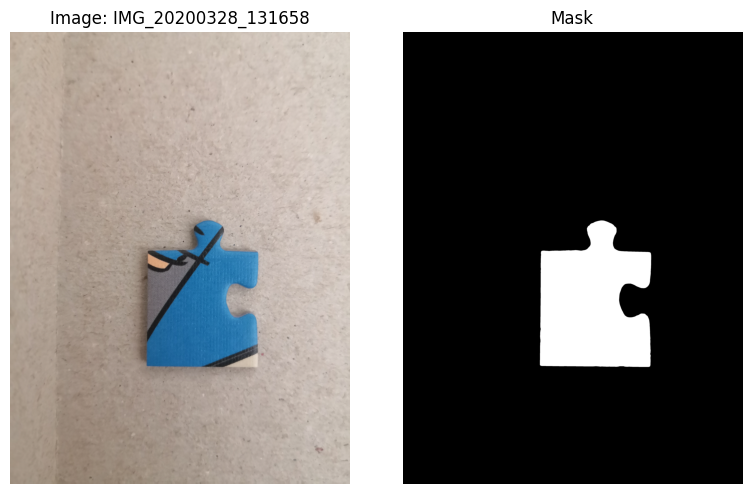

In [218]:
# Start by examining one piece to understand the data
def load_piece(piece_id):
    """Load image and mask for a single piece"""
    img_path = Path(IMAGE_DIR) / f"{piece_id}.jpg"
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Try provided mask first
    mask_path = Path(PROVIDED_MASKS_DIR) / f"{piece_id}_mask.png"
    if not mask_path.exists():
        mask_path = Path(PREDICTED_MASKS_DIR) / f"{piece_id}_mask.png"
    
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    return img_rgb, binary

# Load first piece
all_images = sorted(list(Path(IMAGE_DIR).glob("*.jpg")))
sample_piece_id = all_images[0].stem
# sample_piece_id = "IMG_20200328_131748"
img, mask = load_piece(sample_piece_id)

print(f"Sample piece: {sample_piece_id}")
print(f"Image shape: {img.shape}")
print(f"Mask shape: {mask.shape}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].imshow(img)
axes[0].set_title(f"Image: {sample_piece_id}")
axes[0].axis('off')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Mask")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 2. Extract Contours and Corners

Corners:
[[1581 2482]
 [2800 2520]
 [2769 3796]
 [1546 3766]]


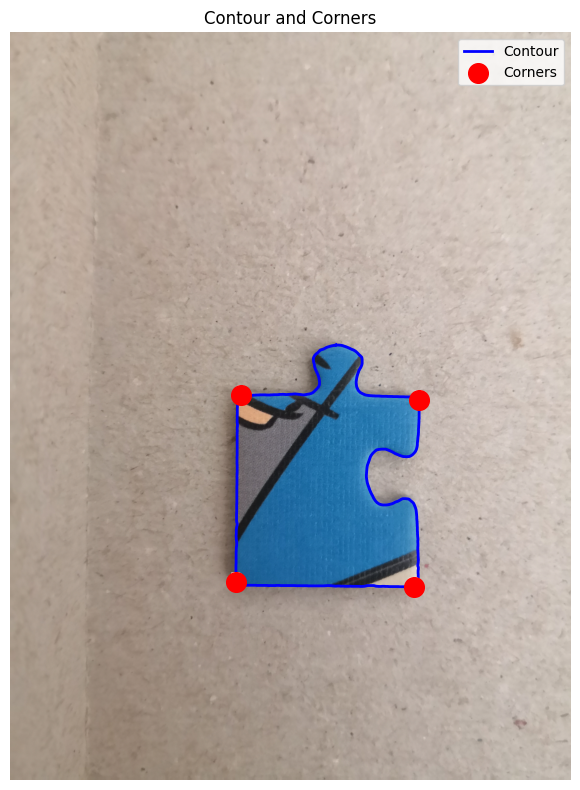

In [219]:
def extract_contour_and_corners(binary, curvature_window=10, curvature_threshold=0.2, min_dist=50):
    """
    Extract contour and detect 4 main corners based on curvature.
    """
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        print("No contours found")
        return None, None

    # Pick the largest contour
    contour = max(contours, key=cv2.contourArea)
    contour = contour.squeeze()
    n_points = len(contour)

    # Compute curvature for each point
    curvatures = []
    for i in range(n_points):
        p_prev = contour[(i - curvature_window) % n_points]
        p_curr = contour[i]
        p_next = contour[(i + curvature_window) % n_points]

        v1 = p_prev - p_curr
        v2 = p_next - p_curr

        angle = np.arccos(
            np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8), -1.0, 1.0)
        )
        curvature = np.pi - angle  # sharper angles have higher curvature
        curvatures.append(curvature)

    curvatures = np.array(curvatures)
    curvatures /= curvatures.max()  # normalize

    # Detect points with high curvature
    corner_indices = np.where(curvatures > curvature_threshold)[0]
    corners = contour[corner_indices]

    # Filter corners by distance to remove clustered points
    filtered = []
    for c in corners:
        if all(np.linalg.norm(c - f) > min_dist for f in filtered):
            filtered.append(c)
    filtered = np.array(filtered)

    # Pick 4 extreme points: TL, TR, BR, BL
    s = filtered.sum(axis=1)
    diff = np.diff(filtered, axis=1).flatten()
    tl = filtered[np.argmin(s)]
    br = filtered[np.argmax(s)]
    tr = filtered[np.argmin(diff)]
    bl = filtered[np.argmax(diff)]
    corners_4 = np.array([tl, tr, br, bl])

    # Sort clockwise starting from top-left
    center = corners_4.mean(axis=0)
    angles = np.arctan2(corners_4[:,1]-center[1], corners_4[:,0]-center[0])
    sorted_indices = np.argsort(angles)
    corners_4 = corners_4[sorted_indices]
    tl_idx = np.argmin(corners_4[:,0] + corners_4[:,1])
    corners_4 = np.roll(corners_4, -tl_idx, axis=0)

    return contour, corners_4

contour, corners = extract_contour_and_corners(mask)

print(f"Corners:\n{corners}")

# Visualize contour and corners
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img)
ax.plot(contour[:, 0], contour[:, 1], 'b-', linewidth=2, label='Contour')
ax.scatter(corners[:, 0], corners[:, 1], c='red', s=200, zorder=5, label='Corners')
for i, corner in enumerate(corners):
    ax.text(corner[0], corner[1], str(i), color='white', fontsize=16, 
            ha='center', va='center', fontweight='bold')
ax.set_title("Contour and Corners")
ax.legend()
ax.axis('off')
plt.tight_layout()
plt.show()


## 3. Extract and Visualize Sides

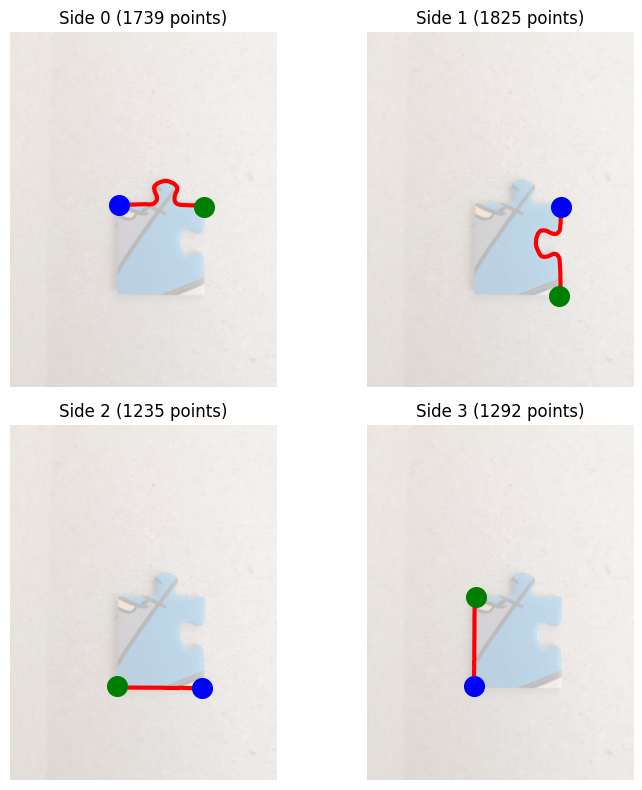

In [187]:
def extract_sides(contour, corners):
    """
    Extract sides along the contour between corners.
    """
    # Find indices of contour points closest to corners
    corner_indices = [np.argmin(np.linalg.norm(contour - c, axis=1)) for c in corners]
    sides = []

    n_points = len(contour)

    for i in range(4):
        idx1 = corner_indices[i]
        idx2 = corner_indices[(i + 1) % 4]

        # Calculate distance in both directions
        if idx1 <= idx2:
            forward_len = idx2 - idx1
            backward_len = idx1 + n_points - idx2
        else:
            forward_len = n_points - idx1 + idx2
            backward_len = idx1 - idx2

        # Choose the shorter segment along the contour
        if forward_len <= backward_len:
            if idx1 <= idx2:
                side_points = contour[idx1:idx2+1]
            else:
                side_points = np.vstack([contour[idx1:], contour[:idx2+1]])
        else:
            # Wrap the other way
            if idx2 <= idx1:
                side_points = contour[idx2:idx1+1][::-1]  # reverse
            else:
                side_points = np.vstack([contour[idx2:], contour[:idx1+1]])[::-1]  # reverse

        sides.append(side_points)

    return sides

sides = extract_sides(contour, corners)

# Visualize each side separately
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i, side in enumerate(sides):
    ax = axes[i]
    # Create blank image
    side_img = np.ones_like(img) * 255
    for pt in side:
        x, y = int(pt[0]), int(pt[1])
        if 0 <= y < img.shape[0] and 0 <= x < img.shape[1]:
            side_img[y, x] = img[y, x]
    
    ax.imshow(img, alpha=0.3)
    ax.plot(side[:, 0], side[:, 1], 'r-', linewidth=3)
    ax.scatter([corners[i, 0]], [corners[i, 1]], c='blue', s=200, zorder=5)
    ax.scatter([corners[(i+1)%4, 0]], [corners[(i+1)%4, 1]], c='green', s=200, zorder=5)
    ax.set_title(f"Side {i} ({len(side)} points)")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Normalize Sides (Geometry + Color)

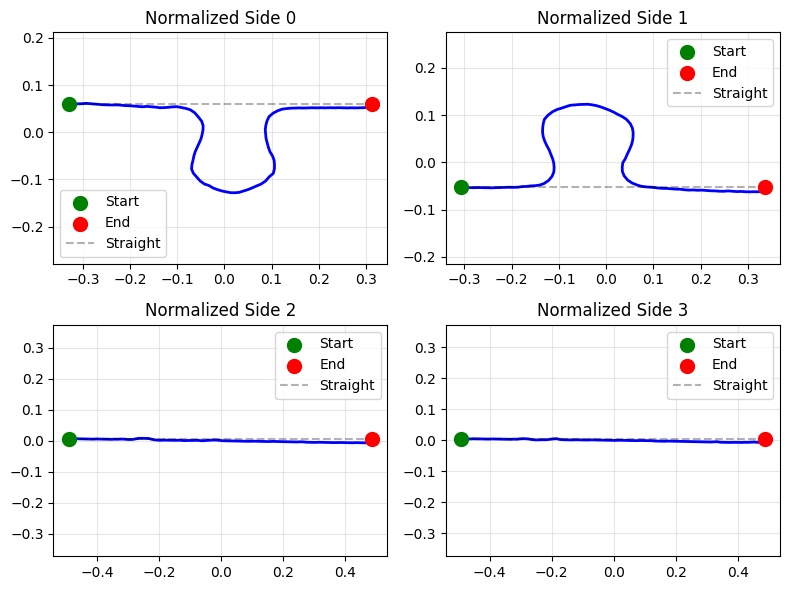

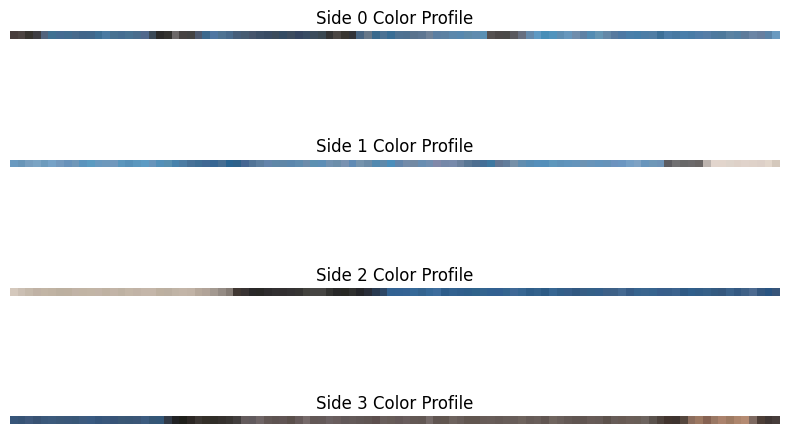

In [188]:
def normalize_side_with_color(side, img_rgb, num_points=100):
    """Normalize side geometry and extract colors"""
    if len(side) < 2:
        return np.zeros((num_points, 2)), np.zeros((num_points, 3))
    
    # Extract colors
    colors = []
    for pt in side:
        x, y = int(pt[0]), int(pt[1])
        if 0 <= y < img_rgb.shape[0] and 0 <= x < img_rgb.shape[1]:
            colors.append(img_rgb[y, x])
        else:
            colors.append([0, 0, 0])
    colors = np.array(colors)
    
    # Normalize geometry
    centroid = side.mean(axis=0)
    side_centered = side - centroid
    
    total_length = np.sum(np.linalg.norm(np.diff(side, axis=0), axis=1))
    if total_length > 0:
        side_scaled = side_centered / total_length
    else:
        side_scaled = side_centered
    
    # Rotate to horizontal
    first_last = side_scaled[-1] - side_scaled[0]
    angle = np.arctan2(first_last[1], first_last[0])
    cos_a, sin_a = np.cos(-angle), np.sin(-angle)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    side_rotated = side_scaled @ rotation_matrix.T
    
    # Interpolate
    t_original = np.linspace(0, 1, len(side_rotated))
    t_new = np.linspace(0, 1, num_points)
    
    interp_x = interp1d(t_original, side_rotated[:, 0], kind='linear')
    interp_y = interp1d(t_original, side_rotated[:, 1], kind='linear')
    normalized_side = np.column_stack([interp_x(t_new), interp_y(t_new)])
    
    # Interpolate colors
    if len(colors) > 1:
        interp_r = interp1d(t_original, colors[:, 0], kind='linear')
        interp_g = interp1d(t_original, colors[:, 1], kind='linear')
        interp_b = interp1d(t_original, colors[:, 2], kind='linear')
        normalized_color = np.column_stack([interp_r(t_new), interp_g(t_new), interp_b(t_new)])
    else:
        normalized_color = np.zeros((num_points, 3))
    
    return normalized_side, normalized_color

# Normalize all sides
normalized_sides = []
normalized_colors = []

for side in sides:
    norm_side, norm_color = normalize_side_with_color(side, img)
    normalized_sides.append(norm_side)
    normalized_colors.append(norm_color)

# Visualize normalized sides
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i, (norm_side, norm_color) in enumerate(zip(normalized_sides, normalized_colors)):
    ax = axes[i]
    
    # Plot geometry
    ax.plot(norm_side[:, 0], norm_side[:, 1], 'b-', linewidth=2)
    ax.scatter(norm_side[0, 0], norm_side[0, 1], c='green', s=100, zorder=5, label='Start')
    ax.scatter(norm_side[-1, 0], norm_side[-1, 1], c='red', s=100, zorder=5, label='End')
    
    # Show straight line for reference
    ax.plot([norm_side[0, 0], norm_side[-1, 0]], 
            [norm_side[0, 1], norm_side[-1, 1]], 
            'k--', alpha=0.3, label='Straight')
    
    ax.set_title(f"Normalized Side {i}")
    ax.axis('equal')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show color strips
fig, axes = plt.subplots(4, 1, figsize=(8, 6))
for i, norm_color in enumerate(normalized_colors):
    color_strip = norm_color.reshape(1, -1, 3).astype(np.uint8)
    axes[i].imshow(color_strip)
    axes[i].set_title(f"Side {i} Color Profile")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 5. Detect Side Types (Flat/Protruding/Sunken)

In [189]:
def classify_side(side, normalized_side, bbox):
    """Classify side as flat, protruding, or sunken using average deviation"""
    x, y, w, h = bbox
    margin = 10
    
    # Boundary check
    side_x = side[:, 0]
    side_y = side[:, 1]
    at_left   = np.sum(side_x < x + margin) > len(side) * 0.8
    at_right  = np.sum(side_x > x + w - margin) > len(side) * 0.8
    at_top    = np.sum(side_y < y + margin) > len(side) * 0.8
    at_bottom = np.sum(side_y > y + h - margin) > len(side) * 0.8
    at_boundary = at_left or at_right or at_top or at_bottom
    
    # Straightness in normalized coordinates
    start = normalized_side[0]
    end = normalized_side[-1]
    line_points = np.linspace(start, end, len(normalized_side))
    deviations = normalized_side - line_points
    max_dev = np.max(np.linalg.norm(deviations, axis=1))
    mean_dev = np.mean(np.linalg.norm(deviations, axis=1))
    std_dev = np.std(np.linalg.norm(deviations, axis=1))
    is_straight = (max_dev < 0.03 and std_dev < 0.015)
    
    if at_boundary or is_straight:
        return 'flat', max_dev, mean_dev
    
    # Compute perpendicular vector of the line in original coordinates
    start_orig = side[0]
    end_orig   = side[-1]
    line_vec = end_orig - start_orig
    perp_vec = np.array([-line_vec[1], line_vec[0]])
    perp_vec = perp_vec / (np.linalg.norm(perp_vec) + 1e-6)
    
    # Compute average signed deviation along the side
    vec_to_points = side - start_orig
    signed_devs = vec_to_points @ perp_vec  # dot product gives signed distance
    avg_dev = np.mean(signed_devs)
    
    if avg_dev > 0:
        return 'sunken', max_dev, mean_dev
    else:
        return 'protruding', max_dev, mean_dev

bbox = cv2.boundingRect(contour)
side_types = []
side_metrics = []

for i, (side, norm_side) in enumerate(zip(sides, normalized_sides)):
    side_type, max_dev, mean_dev = classify_side(side, norm_side, bbox)
    side_types.append(side_type)
    side_metrics.append({'max_dev': max_dev, 'mean_dev': mean_dev})

print("\nSide Classification:")
for i, (stype, metrics) in enumerate(zip(side_types, side_metrics)):
    print(f"  Side {i}: {stype:12s}")

# Determine piece type
num_flat = side_types.count('flat')
if num_flat == 0:
    piece_type = 'interior'
elif num_flat == 1:
    piece_type = 'edge'
elif num_flat == 2:
    flat_indices = [i for i, st in enumerate(side_types) if st == 'flat']
    diff = abs(flat_indices[0] - flat_indices[1])
    piece_type = 'corner' if (diff == 1 or diff == 3) else 'edge'
else:
    piece_type = 'corner'

print(f"\nPiece Type: {piece_type}")


Side Classification:
  Side 0: protruding  
  Side 1: sunken      
  Side 2: flat        
  Side 3: flat        

Piece Type: corner


## 6. Compare Two Pieces - Manual Match Test

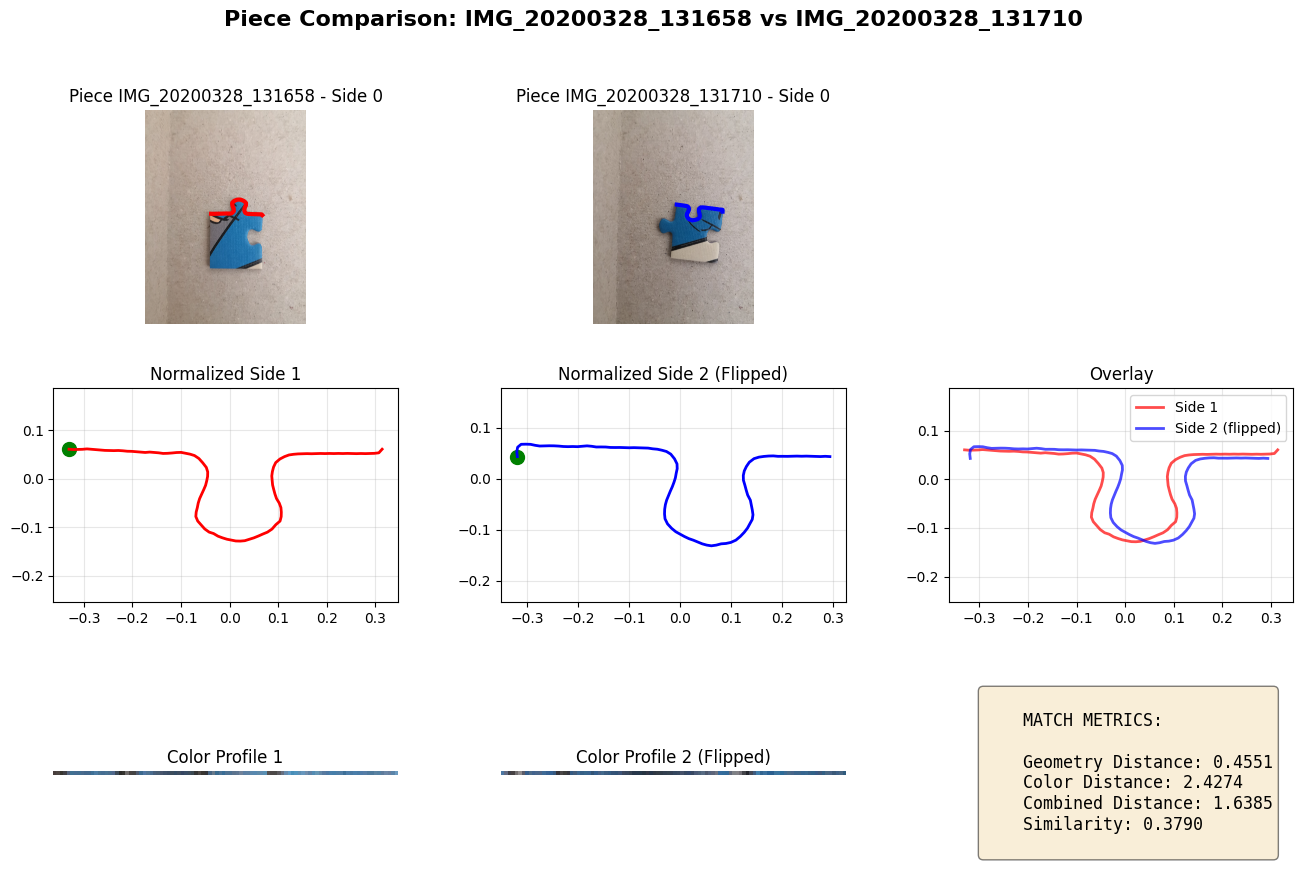


Similarity between IMG_20200328_131658 side 0 and IMG_20200328_131710 side 0: 0.3790


In [190]:
def compare_two_pieces(piece_id1, piece_id2, side_idx1, side_idx2):
    """Compare two specific sides from two pieces"""
    # Load both pieces
    img1, mask1 = load_piece(piece_id1)
    img2, mask2 = load_piece(piece_id2)
    
    # Extract features
    contour1, corners1 = extract_contour_and_corners(mask1)
    contour2, corners2 = extract_contour_and_corners(mask2)
    
    sides1 = extract_sides(contour1, corners1)
    sides2 = extract_sides(contour2, corners2)
    
    norm_side1, norm_color1 = normalize_side_with_color(sides1[side_idx1], img1)
    norm_side2, norm_color2 = normalize_side_with_color(sides2[side_idx2], img2)
    
    # Flip side2 for matching
    norm_side2_flipped = np.copy(norm_side2)
    norm_side2_flipped[:, 0] = -norm_side2_flipped[:, 0]  # Flip horizontally
    norm_side2_flipped[:, 1] = -norm_side2_flipped[:, 1]  # Flip vertically
    norm_side2_flipped = norm_side2_flipped[::-1]         # Reverse point order
    norm_color2_flipped = norm_color2[::-1]

    # Calculate distances
    geom1 = norm_side1.flatten()
    geom2 = norm_side2_flipped.flatten()
    color1 = norm_color1.flatten() / 255.0
    color2 = norm_color2_flipped.flatten() / 255.0
    
    geom_dist = distance.euclidean(geom1, geom2)
    color_dist = distance.euclidean(color1, color2)
    combined_dist = 0.4 * geom_dist + 0.6 * color_dist
    similarity = 1.0 / (1.0 + combined_dist)
    
    # Visualize
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Original images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img1)
    ax1.plot(sides1[side_idx1][:, 0], sides1[side_idx1][:, 1], 'r-', linewidth=3)
    ax1.set_title(f"Piece {piece_id1} - Side {side_idx1}")
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(img2)
    ax2.plot(sides2[side_idx2][:, 0], sides2[side_idx2][:, 1], 'b-', linewidth=3)
    ax2.set_title(f"Piece {piece_id2} - Side {side_idx2}")
    ax2.axis('off')
    
    # Normalized geometry
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(norm_side1[:, 0], norm_side1[:, 1], 'r-', linewidth=2, label='Piece 1')
    ax3.scatter([norm_side1[0, 0]], [norm_side1[0, 1]], c='green', s=100)
    ax3.set_title("Normalized Side 1")
    ax3.axis('equal')
    ax3.grid(True, alpha=0.3)
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(norm_side2_flipped[:, 0], norm_side2_flipped[:, 1], 'b-', linewidth=2, label='Piece 2 (flipped)')
    ax4.scatter([norm_side2_flipped[0, 0]], [norm_side2_flipped[0, 1]], c='green', s=100)
    ax4.set_title("Normalized Side 2 (Flipped)")
    ax4.axis('equal')
    ax4.grid(True, alpha=0.3)
    
    # Overlay
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.plot(norm_side1[:, 0], norm_side1[:, 1], 'r-', linewidth=2, alpha=0.7, label='Side 1')
    ax5.plot(norm_side2_flipped[:, 0], norm_side2_flipped[:, 1], 'b-', linewidth=2, alpha=0.7, label='Side 2 (flipped)')
    ax5.set_title("Overlay")
    ax5.axis('equal')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Color strips
    ax6 = fig.add_subplot(gs[2, 0])
    color_strip1 = norm_color1.reshape(1, -1, 3).astype(np.uint8)
    ax6.imshow(color_strip1)
    ax6.set_title("Color Profile 1")
    ax6.axis('off')
    
    ax7 = fig.add_subplot(gs[2, 1])
    color_strip2 = norm_color2_flipped.reshape(1, -1, 3).astype(np.uint8)
    ax7.imshow(color_strip2)
    ax7.set_title("Color Profile 2 (Flipped)")
    ax7.axis('off')
    
    # Metrics
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    metrics_text = f"""
    MATCH METRICS:
    
    Geometry Distance: {geom_dist:.4f}
    Color Distance: {color_dist:.4f}
    Combined Distance: {combined_dist:.4f}
    Similarity: {similarity:.4f}
    """
    ax8.text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center',
             family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f"Piece Comparison: {piece_id1} vs {piece_id2}", fontsize=16, fontweight='bold')
    plt.show()
    
    return similarity

# Test with two pieces - adjust these IDs based on your data
if len(all_images) > 1:
    test_piece1 = all_images[0].stem
    test_piece2 = all_images[1].stem
    sim = compare_two_pieces(test_piece1, test_piece2, 0, 0)
    print(f"\nSimilarity between {test_piece1} side 0 and {test_piece2} side 0: {sim:.4f}")

## 7. Analyze Best Matches for Sample Piece


Top 5 matches for IMG_20200328_131658 side 0:
Rank   Piece ID        Side   Similarity   Geom Dist    Color Dist   Type        
-------------------------------------------------------------------------------------
1      IMG_20200328_142800 3      0.4068       0.2146       2.2876       sunken      
2      IMG_20200328_151630 3      0.3964       0.1853       2.4139       sunken      
3      IMG_20200328_142800 0      0.3897       0.5700       2.2306       sunken      
4      IMG_20200328_144407 1      0.3891       0.2379       2.4582       sunken      
5      IMG_20200328_161418 3      0.3880       0.2460       2.4644       sunken      


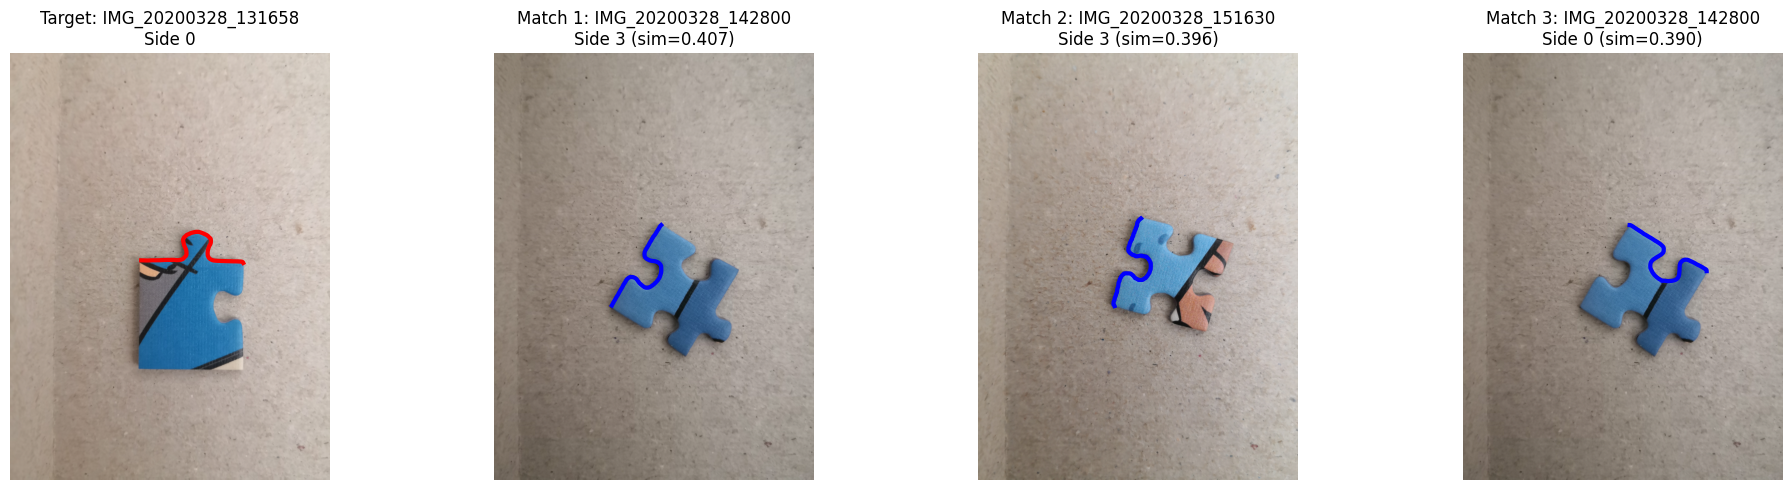

In [ ]:
def find_best_matches_for_piece(target_piece_id, side_idx, top_n=5):
    """Find best matching pieces for a specific side"""
    # Load target piece
    img_target, mask_target = load_piece(target_piece_id)
    contour_target, corners_target = extract_contour_and_corners(mask_target)
    sides_target = extract_sides(contour_target, corners_target)
    norm_side_target, norm_color_target = normalize_side_with_color(sides_target[side_idx], img_target)
    
    # Classify target side
    bbox_target = cv2.boundingRect(contour_target)
    side_type_target, _, _ = classify_side(sides_target[side_idx], norm_side_target, bbox_target)
    
    if side_type_target == 'flat':
        print(f"Side {side_idx} is flat - cannot match")
        return []
    
    # Compare against all other pieces
    matches = []
    
    for img_path in all_images:
        piece_id = img_path.stem
        if piece_id == target_piece_id:
            continue
        
        img, mask = load_piece(piece_id)
        contour, corners = extract_contour_and_corners(mask)

        sides = extract_sides(contour, corners)
        bbox = cv2.boundingRect(contour)
        
        for test_side_idx in range(4):
            norm_side, norm_color = normalize_side_with_color(sides[test_side_idx], img)
            side_type, _, _ = classify_side(sides[test_side_idx], norm_side, bbox)
            
            # Check compatibility
            if side_type == 'flat':
                continue
            if not ((side_type_target == 'sunken' and side_type == 'protruding') or
                    (side_type_target == 'protruding' and side_type == 'sunken')):
                continue
            
            norm_side_flipped = np.copy(norm_side)
            norm_side_flipped[:, 0] = -norm_side_flipped[:, 0]  # Flip horizontally
            norm_side_flipped[:, 1] = -norm_side_flipped[:, 1]  # Flip vertically
            norm_side_flipped = norm_side_flipped[::-1]         # Reverse point order
            norm_color_flipped = norm_color[::-1]

            geom1 = norm_side_target.flatten()
            geom2 = norm_side_flipped.flatten()
            color1 = norm_color_target.flatten() / 255.0
            color2 = norm_color_flipped.flatten() / 255.0

            geom_dist = distance.euclidean(geom1, geom2)
            color_dist = distance.euclidean(color1, color2)
            combined_dist = 0.4 * geom_dist + 0.6 * color_dist
            similarity = 1.0 / (1.0 + combined_dist)
            
            matches.append({
                'piece_id': piece_id,
                'side_idx': test_side_idx,
                'similarity': similarity,
                'geom_dist': geom_dist,
                'color_dist': color_dist,
                'side_type': side_type
            })
    
    # Sort and return top N
    matches.sort(key=lambda x: x['similarity'], reverse=True)
    return matches[:top_n]

# Find best matches for sample piece
best_matches = find_best_matches_for_piece(sample_piece_id, 0, top_n=5)

print(f"\nTop 5 matches for {sample_piece_id} side 0:")
print(f"{'Rank':<6} {'Piece ID':<15} {'Side':<6} {'Similarity':<12} {'Geom Dist':<12} {'Color Dist':<12} {'Type':<12}")
print("-" * 85)
for rank, match in enumerate(best_matches, 1):
    print(f"{rank:<6} {match['piece_id']:<15} {match['side_idx']:<6} "
          f"{match['similarity']:<12.4f} {match['geom_dist']:<12.4f} "
          f"{match['color_dist']:<12.4f} {match['side_type']:<12}")

# Visualize top 3 matches
if len(best_matches) >= 3:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Target piece
    img_target, _ = load_piece(sample_piece_id)
    contour_target, corners_target = extract_contour_and_corners(mask)
    sides_target = extract_sides(contour_target, corners_target)
    
    axes[0].imshow(img_target)
    axes[0].plot(sides_target[0][:, 0], sides_target[0][:, 1], 'r-', linewidth=3)
    axes[0].set_title(f"Target: {sample_piece_id}\nSide 0")
    axes[0].axis('off')
    
    # Top 3 matches
    for i, match in enumerate(best_matches[:3]):
        img_match, mask_match = load_piece(match['piece_id'])
        contour_match, corners_match = extract_contour_and_corners(mask_match)
        sides_match = extract_sides(contour_match, corners_match)
        
        axes[i+1].imshow(img_match)
        axes[i+1].plot(sides_match[match['side_idx']][:, 0], 
                       sides_match[match['side_idx']][:, 1], 'b-', linewidth=3)
        axes[i+1].set_title(f"Match {i+1}: {match['piece_id']}\n"
                            f"Side {match['side_idx']} (sim={match['similarity']:.3f})")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

## 8. Statistics Across Dataset

In [192]:
print("\nComputing statistics across all pieces...")
print("This may take a few minutes...")

piece_type_counts = {'corner': 0, 'edge': 0, 'interior': 0}
side_type_counts = {'flat': 0, 'protruding': 0, 'sunken': 0}
deviation_stats = []

for img_path in all_images:
    piece_id = img_path.stem
    img, mask = load_piece(piece_id)
    contour, corners = extract_contour_and_corners(mask)
    sides = extract_sides(contour, corners)
    bbox = cv2.boundingRect(contour)
    
    side_types_piece = []
    for side in sides:
        norm_side, _ = normalize_side_with_color(side, img)
        side_type, max_dev, mean_dev = classify_side(side, norm_side, bbox)
        side_types_piece.append(side_type)
        side_type_counts[side_type] += 1
        deviation_stats.append({'side_type': side_type, 'max_dev': max_dev, 'mean_dev': mean_dev})
    
    # Determine piece type
    num_flat = side_types_piece.count('flat')
    if num_flat == 0:
        piece_type_counts['interior'] += 1
    elif num_flat == 1:
        piece_type_counts['edge'] += 1
    else:
        piece_type_counts['corner'] += 1

print("\nPiece Type Distribution:")
for ptype, count in piece_type_counts.items():
    print(f"  {ptype.capitalize()}: {count}")

print("\nSide Type Distribution:")
for stype, count in side_type_counts.items():
    print(f"  {stype.capitalize()}: {count}")


Computing statistics across all pieces...
This may take a few minutes...

Piece Type Distribution:
  Corner: 4
  Edge: 81
  Interior: 915

Side Type Distribution:
  Flat: 89
  Protruding: 1780
  Sunken: 2131


## 9. Visualize Multiple Pieces by Type


Visualizing corner pieces...


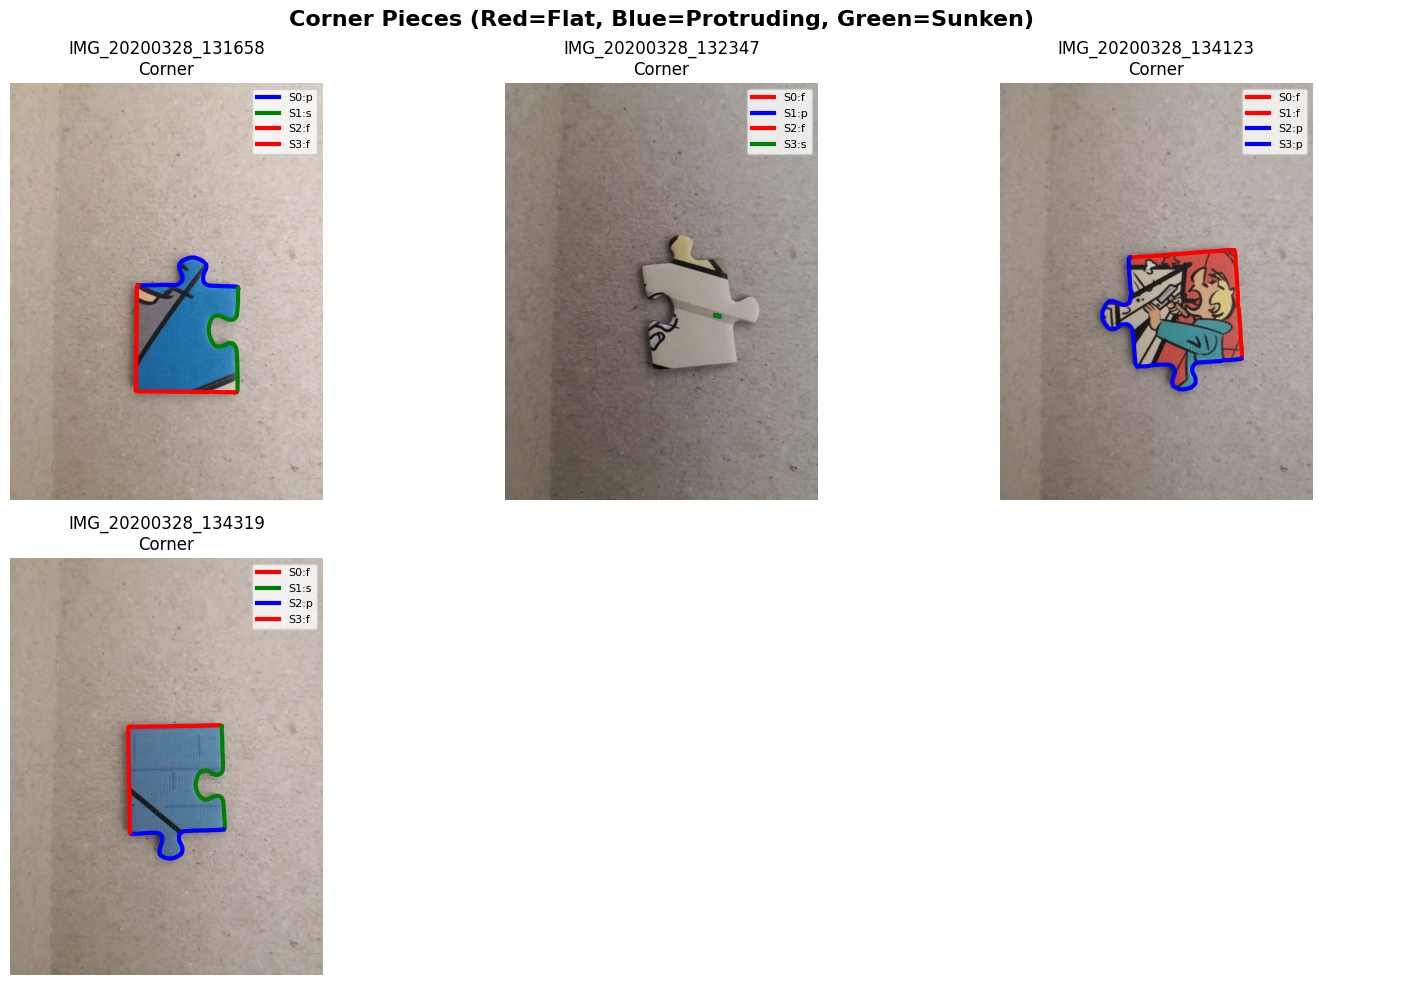


Visualizing edge pieces...


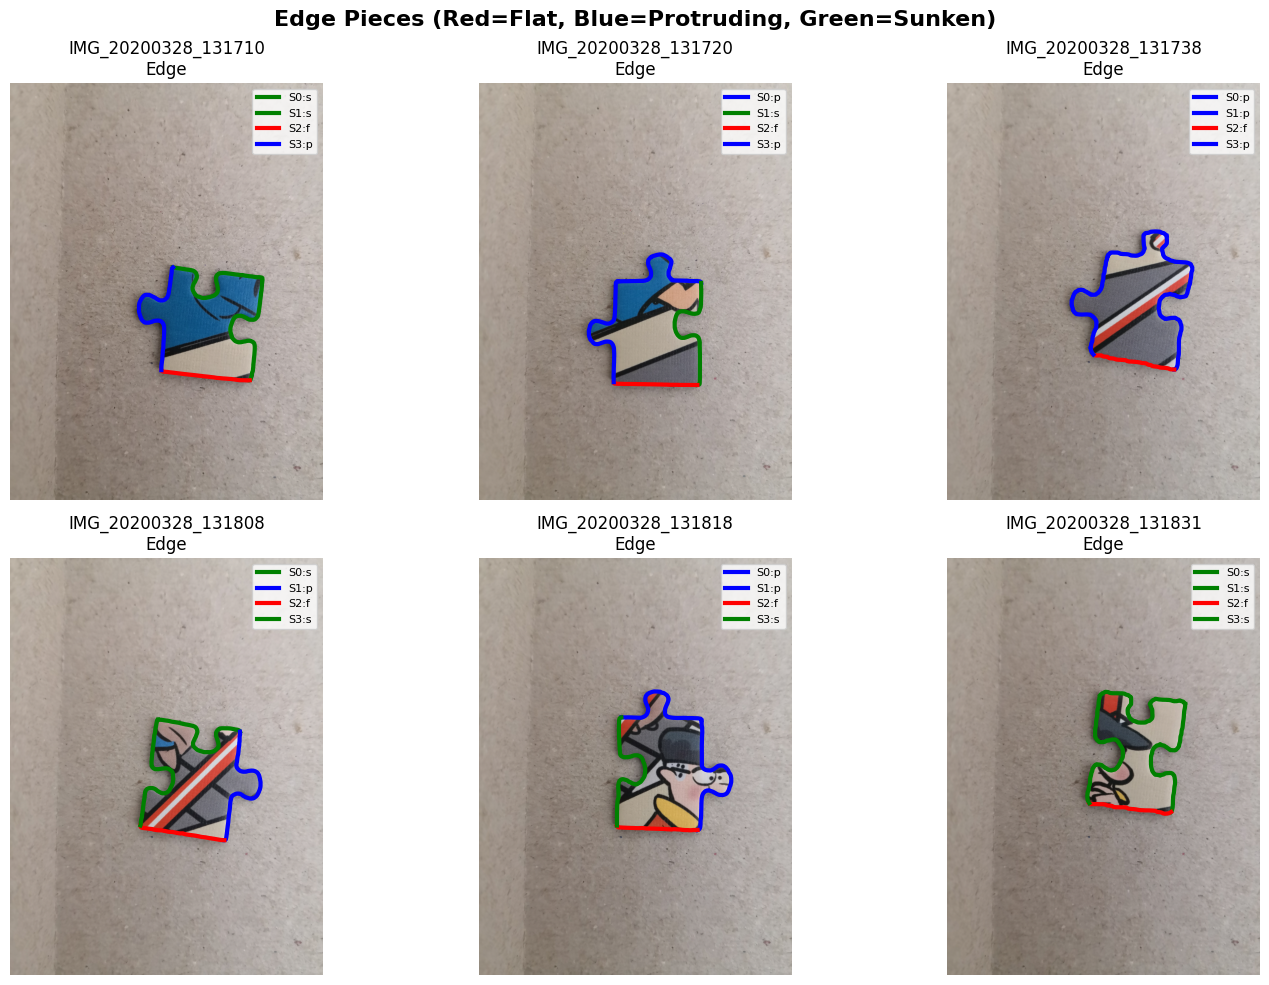


Visualizing interior pieces...


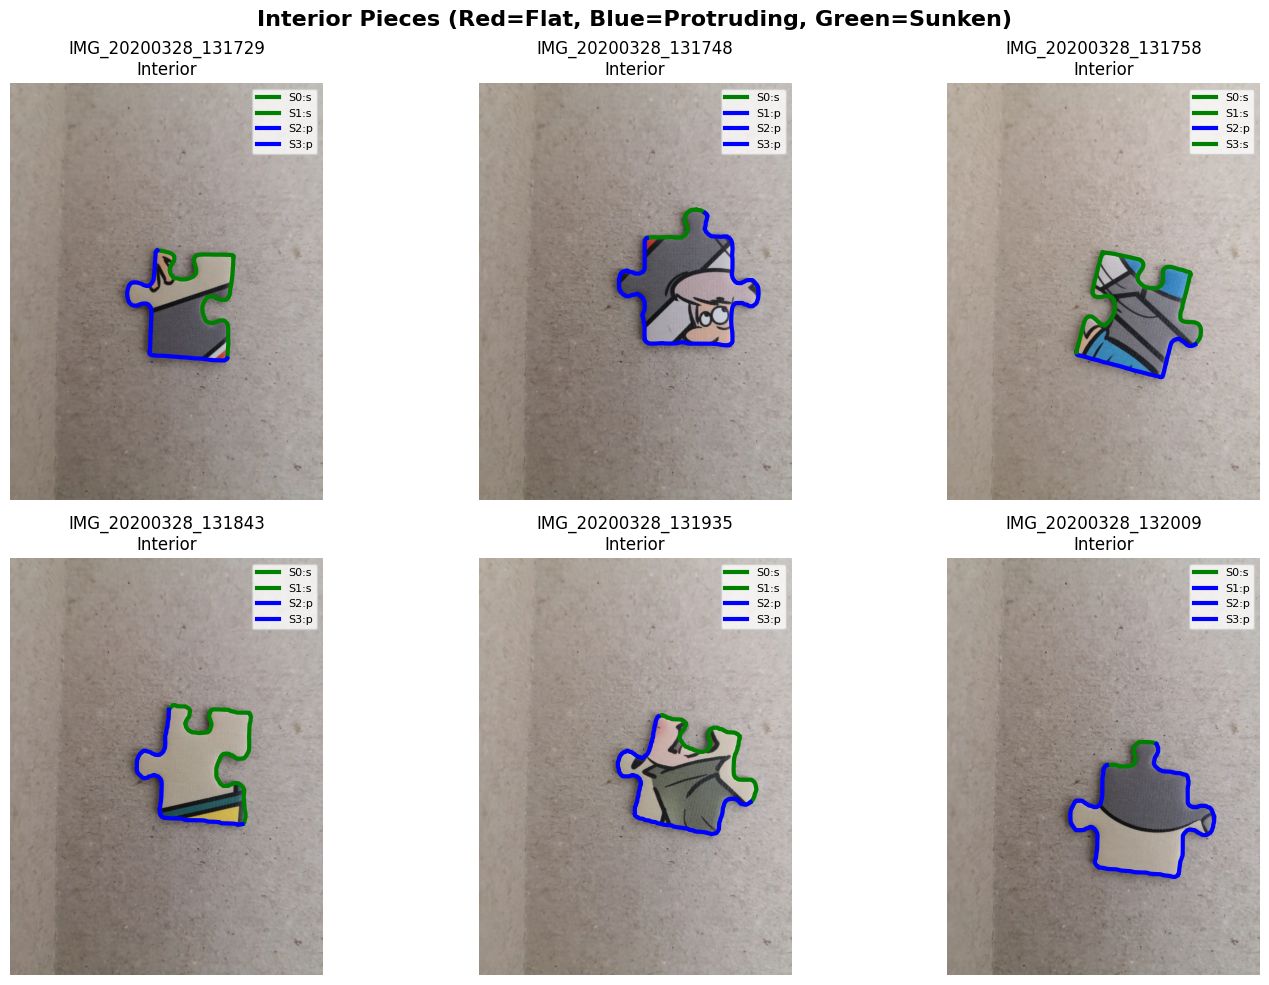

In [193]:
def visualize_pieces_by_type(piece_type, n_samples=6):
    """Visualize sample pieces of a given type"""
    samples = []
    
    for img_path in all_images:
        if len(samples) >= n_samples:
            break
        
        piece_id = img_path.stem
        img, mask = load_piece(piece_id)
        contour, corners = extract_contour_and_corners(mask)
        sides = extract_sides(contour, corners)
        bbox = cv2.boundingRect(contour)
        
        side_types_piece = []
        for side in sides:
            norm_side, _ = normalize_side_with_color(side, img)
            side_type, _, _ = classify_side(side, norm_side, bbox)
            side_types_piece.append(side_type)
        
        # Determine piece type
        num_flat = side_types_piece.count('flat')
        if num_flat == 0:
            ptype = 'interior'
        elif num_flat == 1:
            ptype = 'edge'
        else:
            ptype = 'corner'
        
        if ptype == piece_type:
            samples.append((piece_id, img, sides, side_types_piece))
    
    if len(samples) == 0:
        print(f"No {piece_type} pieces found")
        return
    
    # Visualize
    rows = (len(samples) + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes
    
    for idx, (piece_id, img, sides, side_types_piece) in enumerate(samples):
        ax = axes[idx]
        ax.imshow(img)
        
        # Draw sides with different colors
        colors = {'flat': 'red', 'protruding': 'blue', 'sunken': 'green'}
        for i, (side, stype) in enumerate(zip(sides, side_types_piece)):
            ax.plot(side[:, 0], side[:, 1], color=colors[stype], linewidth=3, label=f'S{i}:{stype[0]}')
        
        ax.set_title(f"{piece_id}\n{piece_type.capitalize()}")
        ax.legend(loc='upper right', fontsize=8)
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(samples), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f"{piece_type.capitalize()} Pieces (Red=Flat, Blue=Protruding, Green=Sunken)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize samples of each type
for ptype in ['corner', 'edge', 'interior']:
    print(f"\nVisualizing {ptype} pieces...")
    visualize_pieces_by_type(ptype, n_samples=6)

## 10. Test Different Similarity Weights

In [ ]:
def test_similarity_weights(piece_id1, side_idx1, piece_id2, side_idx2, weights_list):
    """Test different weight combinations for geometry vs color"""
    # Load and process both pieces
    img1, mask1 = load_piece(piece_id1)
    img2, mask2 = load_piece(piece_id2)
    
    contour1, corners1 = extract_contour_and_corners(mask1)
    contour2, corners2 = extract_contour_and_corners(mask2)
    
    sides1 = extract_sides(contour1, corners1)
    sides2 = extract_sides(contour2, corners2)
    
    norm_side1, norm_color1 = normalize_side_with_color(sides1[side_idx1], img1)
    norm_side2, norm_color2 = normalize_side_with_color(sides2[side_idx2], img2)
    
    # Flip side2
    norm_side2_flipped = norm_side2[::-1]
    norm_color2_flipped = norm_color2[::-1]
    
    # Calculate base distances
    geom1 = norm_side1.flatten()
    geom2 = norm_side2_flipped.flatten()
    color1 = norm_color1.flatten() / 255.0
    color2 = norm_color2_flipped.flatten() / 255.0
    
    geom_dist = distance.euclidean(geom1, geom2)
    color_dist = distance.euclidean(color1, color2)
    
    # Test different weights
    results = []
    for geom_weight, color_weight in weights_list:
        combined_dist = geom_weight * geom_dist + color_weight * color_dist
        similarity = 1.0 / (1.0 + combined_dist)
        results.append({
            'geom_weight': geom_weight,
            'color_weight': color_weight,
            'similarity': similarity,
            'combined_dist': combined_dist
        })
    
    return results, geom_dist, color_dist

# Test different weight combinations
if len(all_images) > 1:
    test_piece1 = all_images[0].stem
    test_piece2 = all_images[1].stem
    
    weights_to_test = [
        (1.0, 0.0),  # Geometry only
        (0.8, 0.2),
        (0.6, 0.4),
        (0.5, 0.5),  # Equal
        (0.4, 0.6),  # Current
        (0.2, 0.8),
        (0.0, 1.0),  # Color only
    ]
    
    results, geom_d, color_d = test_similarity_weights(test_piece1, 0, test_piece2, 0, weights_to_test)
    
    print(f"\nTesting similarity weights on {test_piece1} vs {test_piece2}:")
    print(f"Base geometry distance: {geom_d:.4f}")
    print(f"Base color distance: {color_d:.4f}")
    print(f"\n{'Geom Weight':<12} {'Color Weight':<12} {'Similarity':<12} {'Combined Dist':<15}")
    print("-" * 55)
    for r in results:
        print(f"{r['geom_weight']:<12.1f} {r['color_weight']:<12.1f} {r['similarity']:<12.4f} {r['combined_dist']:<15.4f}")
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    geom_weights = [r['geom_weight'] for r in results]
    similarities = [r['similarity'] for r in results]
    
    ax.plot(geom_weights, similarities, 'bo-', linewidth=2, markersize=8)
    ax.set_xlabel('Geometry Weight', fontsize=12)
    ax.set_ylabel('Similarity Score', fontsize=12)
    ax.set_title('Effect of Weight Balance on Similarity Score', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.1, 1.1)
    
    # Add vertical line at current setting
    ax.axvline(x=0.4, color='r', linestyle='--', label='Current (0.4 geom, 0.6 color)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 11. Analyze Match Quality Distribution

In [ ]:
def sample_random_matches(n_samples=50):
    """Sample random piece pairs and compute their similarity"""
    import random
    
    similarities = []
    geom_dists = []
    color_dists = []
    
    piece_list = [p.stem for p in all_images[:100]]  # Use first 100 for speed
    
    for _ in range(n_samples):
        # Random pieces and sides
        p1, p2 = random.sample(piece_list, 2)
        s1, s2 = random.randint(0, 3), random.randint(0, 3)
        
        try:
            # Load and process
            img1, mask1 = load_piece(p1)
            img2, mask2 = load_piece(p2)
            
            contour1, corners1 = extract_contour_and_corners(mask1)
            contour2, corners2 = extract_contour_and_corners(mask2)
            
            sides1 = extract_sides(contour1, corners1)
            sides2 = extract_sides(contour2, corners2)
            
            bbox1 = cv2.boundingRect(contour1)
            bbox2 = cv2.boundingRect(contour2)
            
            norm_side1, norm_color1 = normalize_side_with_color(sides1[s1], img1)
            norm_side2, norm_color2 = normalize_side_with_color(sides2[s2], img2)
            
            # Check types
            type1, _, _ = classify_side(sides1[s1], norm_side1, bbox1)
            type2, _, _ = classify_side(sides2[s2], norm_side2, bbox2)
            
            # Skip flat sides
            if type1 == 'flat' or type2 == 'flat':
                continue
            
            # Calculate similarity
            norm_side2_flipped = norm_side2[::-1]
            norm_color2_flipped = norm_color2[::-1]
            
            geom1 = norm_side1.flatten()
            geom2 = norm_side2_flipped.flatten()
            color1 = norm_color1.flatten() / 255.0
            color2 = norm_color2_flipped.flatten() / 255.0
            
            geom_dist = distance.euclidean(geom1, geom2)
            color_dist = distance.euclidean(color1, color2)
            combined_dist = 0.4 * geom_dist + 0.6 * color_dist
            similarity = 1.0 / (1.0 + combined_dist)
            
            similarities.append(similarity)
            geom_dists.append(geom_dist)
            color_dists.append(color_dist)
            
        except Exception as e:
            continue
    
    return similarities, geom_dists, color_dists

print("\nSampling random matches to analyze distribution...")
sims, geoms, colors = sample_random_matches(n_samples=100)

print(f"\nRandom Match Statistics (n={len(sims)}):")
print(f"  Similarity:     mean={np.mean(sims):.4f}, std={np.std(sims):.4f}, max={np.max(sims):.4f}")
print(f"  Geom Distance:  mean={np.mean(geoms):.4f}, std={np.std(geoms):.4f}, min={np.min(geoms):.4f}")
print(f"  Color Distance: mean={np.mean(colors):.4f}, std={np.std(colors):.4f}, min={np.min(colors):.4f}")

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(sims, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=np.mean(sims), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sims):.3f}')
axes[0].axvline(x=0.33, color='g', linestyle='--', linewidth=2, label='Best match: 0.33')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Random Match Similarities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(geoms, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=np.mean(geoms), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(geoms):.3f}')
axes[1].set_xlabel('Geometry Distance')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Geometry Distances')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(colors, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(x=np.mean(colors), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(colors):.3f}')
axes[2].set_xlabel('Color Distance')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Color Distances')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()